In [92]:
# spectral analysis 

import numpy as np
import xarray as xr
import time 
from intake import open_catalog
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 
import scipy.ndimage as si
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
from altimetry_tools import specsharp, sharp_smooth, interpolate_nans

import warnings 
warnings.filterwarnings('ignore')

# load coastlines
x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/coastlines_global.nc')  

In [2]:
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
load_sat.keys()

In [4]:
dist = load_sat['dist']
sla = load_sat['sla']
sla_smooth = load_sat['sla_smooth']
vel = load_sat['vel_adt']
vel_smooth = load_sat['vel_smooth']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']

dist_coarse = load_sat['dist_coarse']
lon_coarse_record = load_sat['lon_coarse']
lat_coarse_record = load_sat['lat_coarse']
sla_coarse = load_sat['sla_coarse']

track_record = load_sat['track']
time_record = load_sat['time']

hor_grid_spacing = dist[0][1] - dist[0][0]
coarse_hor_grid_spacing = dist_coarse[0][1] - dist_coarse[0][0]
coarsening_factor = load_sat['coarsening_factor']

In [11]:
t_i = np.array([24])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
good_indi_dist = np.where(track_record == t_i)[0][0]
year_time_tot = ((time_record[good_indi_dist] - time_record[good_indi_dist][0])/(60*60*24))/365
year_time_tot_s = (time_record[good_indi_dist] - time_record[good_indi_dist][0])
year_time = np.mod(year_time_tot, 1)

In [157]:
# -- SPECTRAL PARAMETERS
# -- mesoscale wavenumber band
meso = [70, 250]
# -- half width of window over which to compute spectra 
spec_win = 500  # should be at least as long meso[1], probably twice as large 
# -- number of samples in each spectral estimate 
spec_win_ind = np.int(spec_win / hor_grid_spacing) 
dx = hor_grid_spacing
L = np.int(spec_win_ind * 2) + 1 # = number of grid points contributing to each spectral estimate

# -- for proper estimate of variance (integrating under the spectra) add factor of 2pi later 
# k = np.arange(0, L/2, 1)/L/dx*2*np.pi
# meso_ind = np.where((1/(k/2/np.pi) >= meso[0]) & (1/(k/2/np.pi) <= meso[-1]))[0]
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))  # *2*np.pi;
meso_ind = np.where((1/(k) >= meso[0]) & (1/(k) <= meso[-1]))[0]

# temporal spectra 
dt = year_time_tot_s[2] - year_time_tot_s[1] # need a regular time step (should be regular from satellite, but maybe exceptions)
dt = 856716 / (60*60)  # ~ ten day repeat time (convert seconds to hours)
t_win = (2*365*24) # temporal window == 2 years (in hours)
t_win_ind = t_win / dt
T = np.int(t_win_ind * 2) + 1
f = np.linspace(0, 1.0/(2.0*dt), np.int(T/2))

# -- coarse grid
spec_win_ind_coarse = np.int(spec_win / coarse_hor_grid_spacing)
L_coarse = np.int(spec_win_ind_coarse * 2) + 1
k_coarse = np.linspace(0, 1.0/(2.0*coarse_hor_grid_spacing), np.int(L_coarse/2))  # *2*np.pi;
meso_ind_coarse = np.where((1/(k_coarse) >= meso[0]) & (1/(k_coarse) <= meso[-1]))[0]

In [153]:
t_i = np.array([24])  # s3a 101 # en 3 # J2 24 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 40
good_indi_dist = np.where(track_record == t_i)[0][0]

this_x = dist[good_indi_dist]
this_x_coarse = dist_coarse[good_indi_dist]
this_sla = sla[good_indi_dist].copy()
this_sla_smooth = sla_smooth[good_indi_dist].copy()
this_sla_coarse = sla_coarse[good_indi_dist].copy()
this_track = track_record[good_indi_dist]
this_time = (time_record[good_indi_dist] - time_record[good_indi_dist][0]) / (60*60)

# ----------------------------
# -- COARSEN -- 
x_spec_cen = 4000
x_spec_cen_coarse = 4040
spec_loc = np.where(this_x == x_spec_cen)[0][0]
spec_loc_coarse = np.where((this_x_coarse == x_spec_cen_coarse))[0][0]
# ----------------------------

In [121]:
t_grid = np.arange(dt, t_win*2, dt)  # in hours (~1457 days = 4 years)
# t_grid[-1] / 24 / 365

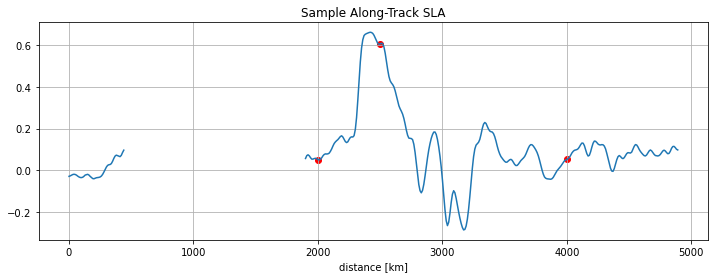

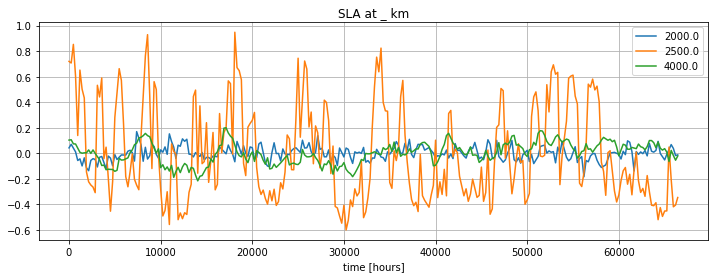

In [180]:
f_spec_locs = 200, 250, 400
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(this_x, this_sla[pass_index, :])
ax.scatter(np.array([f_spec_locs])*10, this_sla[pass_index, f_spec_locs], color='r')
ax.set_title('Sample Along-Track SLA')
ax.set_xlabel('distance [km]')
ax.grid()
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,4))
for i in f_spec_locs:
    ax.plot(this_time, this_sla_interp_t[:, i] - np.nanmean(this_sla_interp_t[:, i]), label=str(i * hor_grid_spacing))
ax.set_title('SLA at _ km')
ax.set_xlabel('time [hours]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()

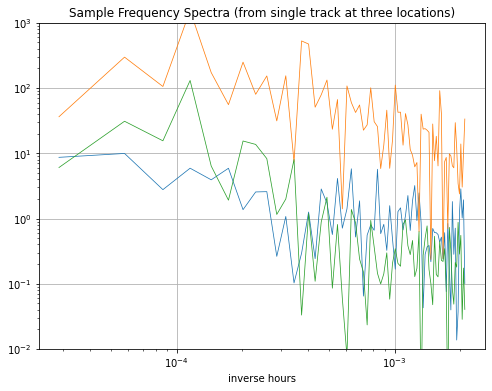

In [183]:
# temporal spectra test (compute at all locations along one track)
t_grid = np.arange(dt, t_win*3, dt)  # in hours (~1457 days = 4 years)
# interpolate nans 
this_sla_interp_t = np.transpose(interpolate_nans(np.transpose(this_sla), this_time, 2))

fig, ax = plt.subplots(1,1,figsize=(8,6))
for i in f_spec_locs:  # range(np.shape(this_sla)[1]):
    this_sig0 = this_sla_interp_t[:, i]  # [time, distance] 
    # select time series of desired length 
    this_sig = this_sig0[0:np.int(np.round(t_win_ind * 2)) + 2]
    # interpolate to regular time grid 
    this_sig_grid0 = np.interp(t_grid[0:np.int(np.round(t_win_ind*2)) + 2], \
                               this_time[0:np.int(np.round(t_win_ind*2)) + 2], this_sig)
    this_sig_grid = this_sig_grid0 - np.nanmean(this_sig_grid0)
    
    LL = len(this_sig_grid)
    test_spec_00 = fft(this_sig_grid, LL) * dt 
    test_spec_11 = 2 * (f[1] - f[0]) * np.abs(test_spec_00[0:(np.int(LL/2))])**2
    # f_spec[:, i] = test_spec_11
    
    ax.plot(f[1:], test_spec_11[1:], linewidth=0.75)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('inverse hours')
ax.set_title('Sample Frequency Spectra (from single track at three locations)')
ax.set_ylim([10**(-2), 10**(3)])
ax.grid()
plt.show()
# 10**-4 = 400 days
# 10**-3 = 42 days 

[-0.03013086  0.00448721  0.02796642 -0.04268802 -0.091242   -0.04232603
  0.02046548  0.04703688  0.058488    0.03781907 -0.01370895 -0.00750748
  0.03134027]
0.0024117945326421106
0.002570816771506564
0.0025616127537000095
-0.06211898195729537
0.0026475283795367207


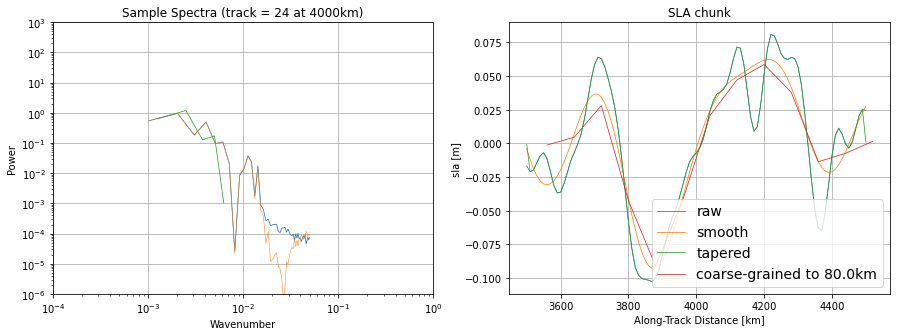

In [159]:
# wavenumber spectra test (compute at one location along one track)

# variance/spectra function check 
# edge taper (if desired) (grid points to taper over at each end)
tape_len0 = 1 # length on each end 
tape_len = tape_len0*2 - 1
nn = np.arange(0, tape_len + 1) - tape_len/2
taper_i = np.exp(-(1/2)*(2.5*nn/(tape_len/2))**2)

true_var = np.nan * np.ones(np.shape(this_sla)[0])
int_var = np.nan * np.ones(np.shape(this_sla)[0])
int_var_tape = np.nan * np.ones(np.shape(this_sla)[0])
int_var_coarse = np.nan * np.ones(np.shape(this_sla_coarse)[0])
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (15, 5))
for ii in [pass_index]:  # range(np.shape(this_sla)[0]):
    this_sig = this_sla[ii, (spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)] - \
        np.nanmean(this_sla[ii, (spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)])
    this_sig_smooth = this_sla_smooth[ii, (spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)] - \
        np.nanmean(this_sla_smooth[ii, (spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)])
    this_sig_coarse = this_sla_coarse[ii, (spec_loc_coarse - spec_win_ind_coarse):(spec_loc_coarse + spec_win_ind_coarse + 1)] - \
        np.nanmean(this_sla_coarse[ii, (spec_loc_coarse - spec_win_ind_coarse):(spec_loc_coarse + spec_win_ind_coarse + 1)])
    print(this_sig_coarse)
    # if there are any nans, skip 
    if (np.sum(np.isnan(this_sig)) > 0) | (np.sum(np.isnan(this_sig_coarse)) > 0):
        print('nan in set')
        continue
    
    LL = len(this_sig)  
    LL_coarse = len(this_sig_coarse)
    test_spec_00 = fft(this_sig, LL) * hor_grid_spacing 
    test_spec_11 = 2 * (k[1] - k[0]) * np.abs(test_spec_00[0:(np.int(LL/2))])**2
    test_spec_22 = (k[1] - k[0]) * (np.nansum(test_spec_11[1:-1]) + test_spec_11[-1]/2)
    # plot spectra 
    ax.plot(k[1:], test_spec_11[1:], linewidth=0.75)
    ax2.plot(this_x[(spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)], this_sig, linewidth=0.75, label='raw')
    ax2.plot(this_x[(spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)], this_sig_smooth, linewidth=0.75, label='smooth')
    # apply taper and recompute spectra
    this_sig[0:tape_len0] = this_sig[0:tape_len0] * taper_i[0:tape_len0]
    this_sig[-tape_len0:] = this_sig[-tape_len0:] * taper_i[-tape_len0:]    
    test_spec_0 = fft(this_sig, LL) * hor_grid_spacing
    test_spec_1 = 2 * (k[1] - k[0]) * np.abs(test_spec_0[0:(np.int(LL/2))])**2
    test_spec_tape = (k[1] - k[0]) * (np.nansum(test_spec_1[1:-1]) + test_spec_1[-1]/2)
    # plot tapered spectra
    ax.plot(k[1:], test_spec_1[1:], linewidth=0.5)
    ax2.plot(this_x[(spec_loc - spec_win_ind):(spec_loc + spec_win_ind + 1)], this_sig, linewidth=0.75, label='tapered')
    # apply taper to coarsened data and compute spectra
    this_sig_coarse[0:tape_len0] = this_sig_coarse[0:tape_len0] * taper_i[0:tape_len0]
    this_sig_coarse[-tape_len0:] = this_sig_coarse[-tape_len0:] * taper_i[-tape_len0:]    
    test_coarse_spec_0 = fft(this_sig_coarse, LL_coarse) * coarse_hor_grid_spacing
    test_coarse_spec_1 = 2 * (k_coarse[1] - k_coarse[0]) * np.abs(test_coarse_spec_0[0:(np.int(LL_coarse/2))])**2
    test_coarse_spec = (k_coarse[1] - k_coarse[0]) * (np.nansum(test_coarse_spec_1[1:-1]) + test_coarse_spec_1[-1]/2)
    # plot tapered spectra
    ax.plot(k_coarse[1:], test_coarse_spec_1[1:], linewidth=0.75)
    ax2.plot(this_x_coarse[(spec_loc_coarse - spec_win_ind_coarse):(spec_loc_coarse + spec_win_ind_coarse + 1)], \
             this_sig_coarse, linewidth=0.75, label='coarse-grained to ' + str(hor_grid_spacing*coarsening_factor) + 'km')
    
    
    # store variance estimates
    true_var[ii] = np.nanstd(this_sig)**2
    int_var[ii] = test_spec_22
    int_var_tape[ii] = test_spec_tape
    int_var_coarse[ii] = test_coarse_spec
    
print(np.nanmean(true_var))
print(np.nanmean(int_var))
print(np.nanmean(int_var_tape))
print((np.nanmean(true_var) - np.nanmean(int_var_tape))/np.nanmean(true_var))
print(np.nanmean(int_var_coarse))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(-6), 10**(3)])
ax.set_xlim([1*10**(-4), 10**(0)])
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.set_title('Sample Spectra (track = ' + str(t_i[0]) + ' at ' + str(x_spec_cen) + 'km)')
ax2.set_xlabel('Along-Track Distance [km]')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=14)
ax2.set_title('SLA chunk')
ax2.set_ylabel('sla [m]')
ax.grid()
ax2.grid()
plt.show()
# f.savefig(this_sat + '_sample_spectral_differences', dpi=300)


In [ ]:
fig, ax = plt.subplots()
ff, kk = np

In [36]:
# sample raw_spectra (single track)
this_x = dist[good_indi_dist]
this_sla = sla[good_indi_dist].copy()
this_sla_smooth = sla_smooth[good_indi_dist].copy()
this_track = track_record[good_indi_dist]
single = 1  # single track or not 
taper = 0
taper_len = 1  # points to taper at end
time_indices = np.arange(0, 30)
increment = 1
%time meso_slope_single, meso_spectra_single = spectra_slopes(this_track, this_x, this_sla, k, L, dx, \
                                                              meso, spec_win, spec_win_ind, \
                                                              taper, taper_len, single, increment)

CPU times: user 14.7 s, sys: 53.9 ms, total: 14.7 s
Wall time: 14.8 s


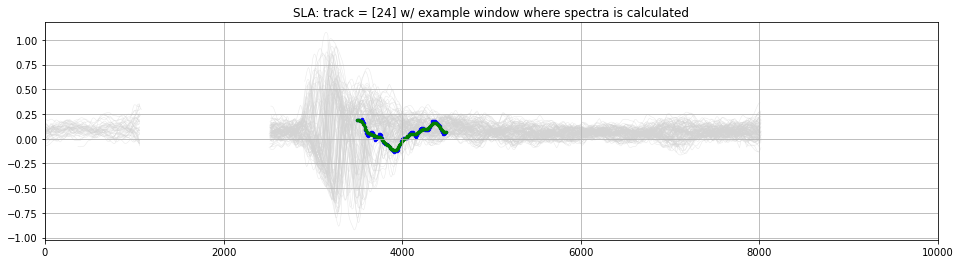

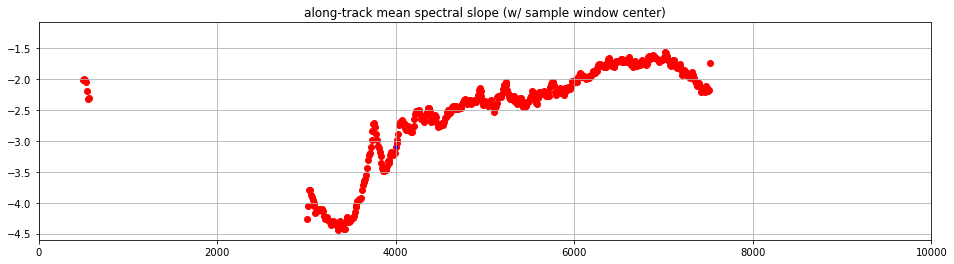

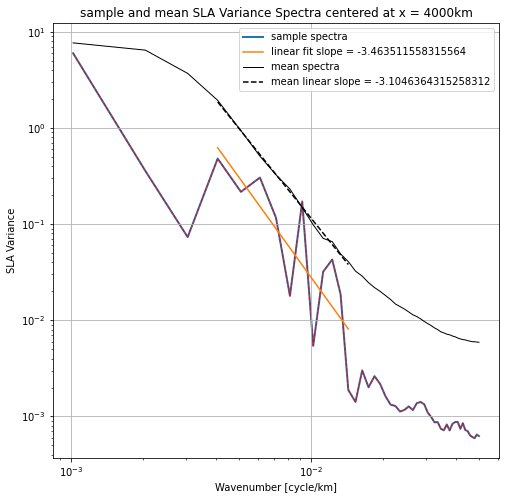

In [37]:
# plot sample spectra from one track
save_f = 0
jj = pass_index  # cycle

# -- [plot sla]
f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(sla[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5, zorder=0)
ax.scatter(dist[good_indi_dist][(spec_loc-spec_win_ind):(spec_loc+spec_win_ind)], sla[good_indi_dist][jj, (spec_loc-spec_win_ind):(spec_loc+spec_win_ind)], color='b', s=6, zorder=1)    
ax.scatter(dist[good_indi_dist][(spec_loc-spec_win_ind):(spec_loc+spec_win_ind)], \
           sla_smooth[good_indi_dist][jj, (spec_loc-spec_win_ind):(spec_loc+spec_win_ind)], color='g', s=6, zorder=1)    

ax.set_xlim([0, 10000])    
ax.set_title('SLA: track = ' + str(t_i) + ' w/ example window where spectra is calculated')
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_sample_spec_window', dpi=300)

# -- plot spectra as a function of transect distance 
f, ax = plt.subplots(1, 1, figsize = (16, 4))
good_slope_i = np.isfinite(np.nanmean(meso_slope_single[:, :, 0], axis=0))
ax.scatter(dist[good_indi_dist][good_slope_i], np.nanmean(meso_slope_single[:, :, 0], axis=0)[good_slope_i], color='r')
ax.scatter(dist[good_indi_dist][spec_loc], np.nanmean(meso_slope_single[:, spec_loc, 0], axis=0), color='b', s=6)
ax.set_xlim([0, 10000])  
ax.set_title('along-track mean spectral slope (w/ sample window center)')
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sample_mean_slope', dpi=300)

# -- plot sample and mean spectra 
f, ax = plt.subplots(1, 1, figsize = (8, 8))
# plot spectra for each x position 
for i in range(jj, jj + 1):  # range(spec_loc, spec_loc + 5):  # 
    ax.plot(k[1:], meso_spectra_single[i, spec_loc, 1:], linewidth=2, label='sample spectra', zorder=0)
    ax.plot(k[meso_ind], 10**np.polyval(meso_slope_single[i, spec_loc, :], np.log10(k[meso_ind])), \
            label='linear fit slope = ' + str(meso_slope_single[i, spec_loc, 0]))
ax.plot(k[1:], test_spec_11[1:], linewidth=1, color='r', linestyle='--', zorder=1)
# ax.plot(k[1:], test_spec_1[1:], linewidth=0.5, color='c')
    
# plot mean spectra (time mean)    
ax.plot(k[1:], np.nanmean(meso_spectra_single[:, spec_loc, 1:], axis=0), linewidth=1, color='k', label='mean spectra')
# linear fit to mean spectra 
meso_p = np.polyfit(np.log10(k[meso_ind]), np.log10(np.nanmean(meso_spectra_single[:, spec_loc, :], axis=0)[meso_ind]), 1)
fit_i = 10**np.polyval(meso_p, np.log10(k[meso_ind]))   
ax.plot(k[meso_ind], fit_i, color='k', linestyle='--', label='mean linear slope = ' + str(np.nanmean(meso_slope_single[:, spec_loc, 0])))    
# ax.set_ylim([10**(-6), 10**(3)])
# ax.set_xlim([1*10**(-4), 10**(0)])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('sample and mean SLA Variance Spectra centered at x = ' + str(x_spec_cen) + 'km')
ax.set_xlabel('Wavenumber [cycle/km]')
ax.set_ylabel('SLA Variance')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sample_mean_spectra', dpi=300)

In [38]:
# raw_spectra
meso = [70, 250]
# check and redefine mesoscale range if grid scale (and nyquist wavenumber) should narrow this range 
nyquist_wavelength = 2
coarse_res = hor_grid_spacing * nyquist_wavelength
if coarse_res > meso[0]:
    meso = [np.int(coarse_res), meso[-1]]

single = 0      # single track or not 
taper = 1       # do we apply taper at edges of spectra
taper_len = 2   # if taper, length of taper in grid cells 
increment = 6
%time meso_slope_out, meso_spectra_out = spectra_slopes(track_record, dist, sla, k, L, dx, \
                                                        meso, spec_win, spec_win_ind, \
                                                        taper, taper_len, single, increment)


CPU times: user 9min 21s, sys: 6.33 s, total: 9min 27s
Wall time: 9min 28s


In [39]:
# -- smoothed spectra
meso = [70, 250]
# check and redefine mesoscale range if grid scale (and nyquist wavenumber) should narrow this range 
nyquist_wavelength = 2
coarse_res = hor_grid_spacing * coarsening_factor * nyquist_wavelength
if coarse_res > meso[0]:
    meso = [np.int(coarse_res), meso[-1]]
print(meso)

[100, 250]


In [40]:
# -- smoothed spectra
single = 0
taper = 1
taper_len = 2
increment = 6
meso_slope_smooth_out, meso_spectra_smooth_out = spectra_slopes(track_record, dist, sla_smooth, k, L, dx, \
                                                                meso, spec_win, spec_win_ind, \
                                                                taper, taper_len, single, increment)

In [41]:
# -- coarsened spectra
# -- use same redefined meso window from smoothed section above 
single = 0
taper = 1
taper_len = 1
increment = 1  # grid increment to compute spectra along
meso_slope_coarse_out, meso_spectra_coarse_out = spectra_slopes(track_record, dist_coarse, sla_coarse, \
                                                                k_coarse, L_coarse, coarse_hor_grid_spacing, \
                                                                meso, spec_win, spec_win_ind_coarse, \
                                                                taper, taper_len, single, increment)

In [42]:
print(meso_spectra_coarse_out[good_indi_dist][pass_index, spec_loc_coarse, 2])
print(sla_coarse[good_indi_dist][pass_index, spec_loc_coarse])

this_x = dist_coarse[good_indi_dist]
this_sla = sla_coarse[good_indi_dist].copy()
x_mod = np.arange(np.where(this_x>=spec_win)[0][0], len(this_x) - np.where(this_x>=spec_win)[0][0] - 1)
this_si = this_sla[pass_index, :].copy()
xx = np.where(this_x[x_mod] == x_spec_cen_coarse)[0][0]
this_sig = this_si[(x_mod[xx] - spec_win_ind_coarse):(x_mod[xx] + spec_win_ind_coarse + 1)].copy()
this_sig_anom = this_sig - np.nanmean(this_sig)
this_fft = fft(this_sig_anom, L) * dx
fft_out = 2 * (k[1] - k[0]) * np.abs(this_fft[0:(np.int(np.floor(L/2)))])**2
print(fft_out)

0.6915995750879926
-0.0017824499737617207
[1.57218771e-34 4.98541290e-03 2.85558187e-02 8.32994031e-02
 1.61413269e-01 2.28434467e-01 2.45800387e-01 2.02186758e-01
 1.23459087e-01 5.18664044e-02 1.44039129e-02 8.35590769e-03
 1.30233918e-02 1.20975488e-02 5.10864450e-03 1.18849273e-03
 5.95382951e-03 1.56374037e-02 2.20226673e-02 2.07158905e-02
 1.41999584e-02 8.17664749e-03 6.10023431e-03 7.02659839e-03
 7.69445606e-03 6.04285379e-03 2.92245598e-03 9.05230772e-04
 1.63063779e-03 4.19695777e-03 6.04085463e-03 5.40859943e-03
 2.97557615e-03 1.01642614e-03 1.05175182e-03 2.45913612e-03
 3.39903752e-03 2.85114921e-03 1.49216490e-03 6.74379476e-04
 9.25724540e-04 1.65640974e-03 2.08721022e-03 2.05714299e-03
 1.86229321e-03 1.66118206e-03 1.35799905e-03 9.70017232e-04
 7.64423701e-04 9.01550904e-04]


In [43]:
# spectra matrix [track][time, distance, wavenumber]
# remember spectra calculated at 60 km grid intervals 

cutoff_i = np.where((1/(k) >= hor_grid_spacing*coarsening_factor*2))[0][-1]
sgs_ind = np.where((1/(k) <= hor_grid_spacing*coarsening_factor))[0]
int_ind = np.where((1/(k) >= hor_grid_spacing*coarsening_factor) & (1/(k) <= hor_grid_spacing*coarsening_factor*np.pi))[0]
large_ind = np.where((1/(k) >= hor_grid_spacing*coarsening_factor*np.pi))[0][1:]

# -- integrate under raw and filtered spectra 
int_raw = []
int_s = []
int_coarse = []
int_large = []
for i in tqdm(range(len(meso_spectra_out))):
    int_raw_0 = np.nan * np.ones((np.shape(meso_spectra_out[i])[0], np.shape(meso_spectra_out[i])[1]))
    int_smooth_1 = np.nan * np.ones((np.shape(meso_spectra_out[i])[0], np.shape(meso_spectra_out[i])[1]))
    int_raw_1 = np.nan * np.ones((np.shape(meso_spectra_out[i])[0], np.shape(meso_spectra_out[i])[1]))
    int_coarse_1 = np.nan * np.ones((np.shape(meso_spectra_out[i])[0], np.shape(meso_spectra_coarse_out[i])[1]))
    for j in range(np.shape(meso_spectra_out[i])[0]):
        this_cycle = meso_spectra_out[i][j, :, :]
        this_smooth_cycle = meso_spectra_smooth_out[i][j, :, :]
        this_coarse_cycle = meso_spectra_coarse_out[i][j, :, :]
        
        coarse_spec = interp1d(k_coarse, this_coarse_cycle, axis=1)
        this_coarse_on_raw = coarse_spec(k[1:cutoff_i + 1])
        
        # -- integrage over all wavenumbers
        int_raw_0[j, :] = (k[1] - k[0]) * (np.nansum(this_cycle[:, 1:-1], axis=1))
        # -- integrate over wavelengths greater than nyquist wavelengths
        int_raw_1[j, :] = (k[1] - k[0]) * (np.nansum(this_cycle[:, 1:cutoff_i+1], axis=1))
        int_smooth_1[j, :] = (k[1] - k[0]) * (np.nansum(this_smooth_cycle[:, 1:cutoff_i+1], axis=1))
        int_coarse_1[j, :] = (k[1] - k[0]) * (np.nansum(this_coarse_on_raw, axis=1))

    int_raw.append(int_raw_0)
    int_s.append(int_smooth_1)
    int_large.append(int_raw_1)
    int_coarse.append(int_coarse_1)
    

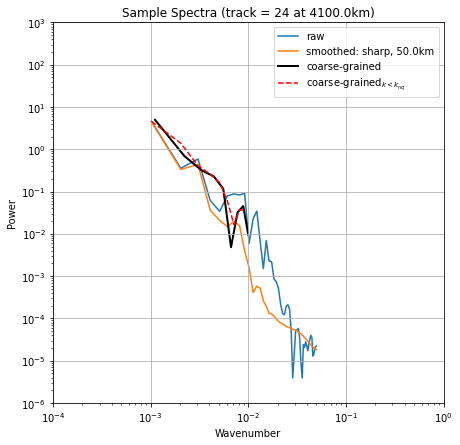

In [52]:
jj = pass_index 
spec_loc_sub_grid = 410
this_coarse_cycle = meso_spectra_coarse_out[good_indi_dist][jj, spec_loc_coarse, :]
this_coarse_on_raw = np.interp(k[1:cutoff_i + 1], k_coarse, this_coarse_cycle)

f, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(k[1:], meso_spectra_out[good_indi_dist][jj, spec_loc_sub_grid, 1:], zorder=0, label='raw')
ax.plot(k[1:], meso_spectra_smooth_out[good_indi_dist][jj, spec_loc_sub_grid, 1:], \
        zorder=0, label='smoothed: ' + filter_type + ', ' + str(coarse_hor_grid_spacing) + 'km')

# ax.plot(k_coarse[1:], test_coarse_spec_1[1:], linewidth=0.5)
ax.plot(k_coarse[1:], meso_spectra_coarse_out[good_indi_dist][jj, spec_loc_coarse, 1:], color='k', \
        zorder=1, linewidth=2, label='coarse-grained')
ax.plot(k[1:cutoff_i + 1], this_coarse_on_raw, color='r', \
        zorder=2, linestyle='--', label=r'coarse-grained$_{k<k_{nq}}$')
ax.set_ylim([10**(-6), 10**(3)])
ax.set_xlim([1*10**(-4), 10**(0)])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.set_title('Sample Spectra (track = ' + str(t_i[0]) + ' at ' + str(spec_loc_sub_grid*hor_grid_spacing) + 'km)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()
f.savefig(this_sat + '_sample_spectral_differences_post_coarsened', dpi=300)


In [53]:
# lat/lon key
for i in range(len(lon_record)):
    if i < 1:
        lon_t = lon_record[i]
        lat_t = lat_record[i]
        track_t = np.ones(len(lon_record[i])) * track_record[i]
    else:
        lon_t = np.concatenate((lon_t, lon_record[i]))
        lat_t = np.concatenate((lat_t, lat_record[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon_record[i])) * track_record[i]))

In [56]:
# bin variances 
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65

step = 2.5
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 20
mean_sla = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_var = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_var_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_var_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_var_large = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(len(lon_bins) - 1)):
    for j in range(len(lat_bins) - 1):
        this_lon0 = lon_bins[i]
        this_lon1 = lon_bins[i+1]
        this_lat0 = lat_bins[j]
        this_lat1 = lat_bins[j+1]
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # -- for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1))[0]
            # -- repeat for coarse grid 
            inn2_coarse = np.where((lon_coarse_record[ai[tib]] > this_lon0) &\
                                   (lon_coarse_record[ai[tib]] < this_lon1) &\
                                   (lat_coarse_record[ai[tib]] > this_lat0) &\
                                   (lat_coarse_record[ai[tib]] < this_lat1))[0]
            
            if count < 1:
                sla_i = sla[ai[tib]][:, inn2].flatten()
                # adt_i = adt[ai[tib]][:, inn2].flatten() 
                integrated_var = int_raw[ai[tib]][:, inn2].flatten()  # integrated across all k
                integrated_var_s = int_s[ai[tib]][:, inn2].flatten()  # integrated smoothed across all k
                integrated_var_large = int_large[ai[tib]][:, inn2].flatten()  # integrated across k < k_{nq}
                integrated_var_coarse = int_coarse[ai[tib]][:, inn2_coarse].flatten() # integrated coarse across k < k_{nq}
                if len(np.shape(meso_slope_out[ai[tib]])) > 2:
                    sloper = meso_slope_out[ai[tib]][:, inn2, 0].flatten()
                    sloper1 = meso_slope_smooth_out[ai[tib]][:, inn2, 0].flatten()
                    sloper_coarse = meso_slope_coarse_out[ai[tib]][:, inn2_coarse, 0].flatten()
                else:
                    sloper = meso_slope_out[ai[tib]][:, inn2].flatten()
                    sloper1 = meso_slope_smooth_out[ai[tib]][:, inn2].flatten()
                    sloper_coarse = meso_slope_coarse_out[ai[tib]][:, inn2_coarse].flatten()
                count = count + 1
            else:
                sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
                # adt_i = np.append(adt_i, adt[ai[tib]][:, inn2].flatten())   
                integrated_var = np.append(integrated_var, int_raw[ai[tib]][:, inn2].flatten())
                integrated_var_s = np.append(integrated_var_s, int_s[ai[tib]][:, inn2].flatten())
                integrated_var_large = np.append(integrated_var_large, int_large[ai[tib]][:, inn2].flatten())
                integrated_var_coarse = np.append(integrated_var_coarse, int_coarse[ai[tib]][:, inn2_coarse].flatten())
                if len(np.shape(meso_slope_out[ai[tib]])) > 2:
                    sloper = np.append(sloper, meso_slope_out[ai[tib]][:, inn2, 0].flatten())
                    sloper1 = np.append(sloper1, meso_slope_smooth_out[ai[tib]][:, inn2, 0].flatten())
                    sloper_coarse = np.append(sloper_coarse, meso_slope_coarse_out[ai[tib]][:, inn2_coarse, 0].flatten())
                else:
                    sloper = np.append(sloper, meso_slope_out[ai[tib]][:, inn2].flatten())
                    sloper1 = np.append(sloper1, meso_slope_smooth_out[ai[tib]][:, inn2].flatten())
                    sloper_coarse = np.append(sloper_coarse, meso_slope_coarse_out[ai[tib]][:, inn2_coarse].flatten())

        if (len(ai) > 1):
            if (len(sla_i) > thresh):
                mean_sla[i, j] = np.nanmean(sla_i**2)           # like a raw eddy energy estimate 
                # mean_adt[i, j] = np.nanmean(adt_i)              # raw adt
                mean_var[i, j] = np.nanmean(integrated_var)
                mean_var_smooth[i, j] = np.nanmean(integrated_var_s)
                mean_var_large[i, j] = np.nanmean(integrated_var_large)
                mean_var_coarse[i, j] = np.nanmean(integrated_var_coarse)
                mean_slope[i, j] = np.nanmean(sloper)
                mean_slope_smooth[i, j] = np.nanmean(sloper1)
                mean_slope_coarse[i, j] = np.nanmean(sloper_coarse)
        ai = 0

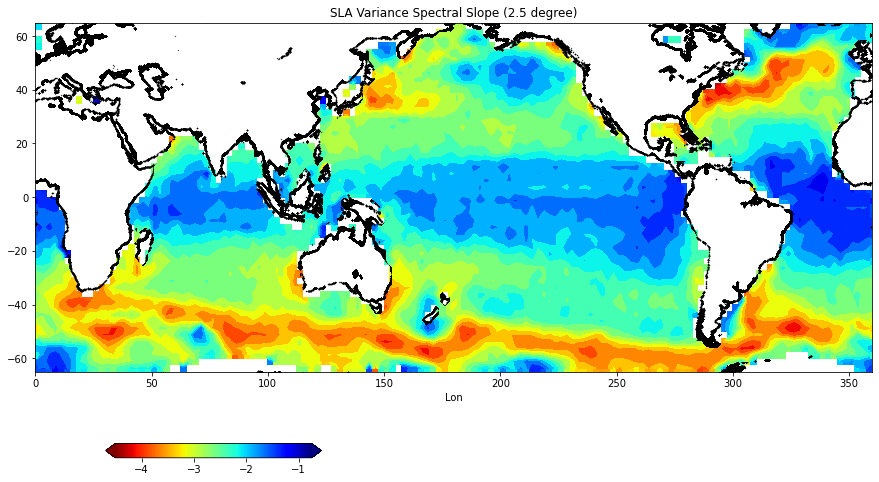

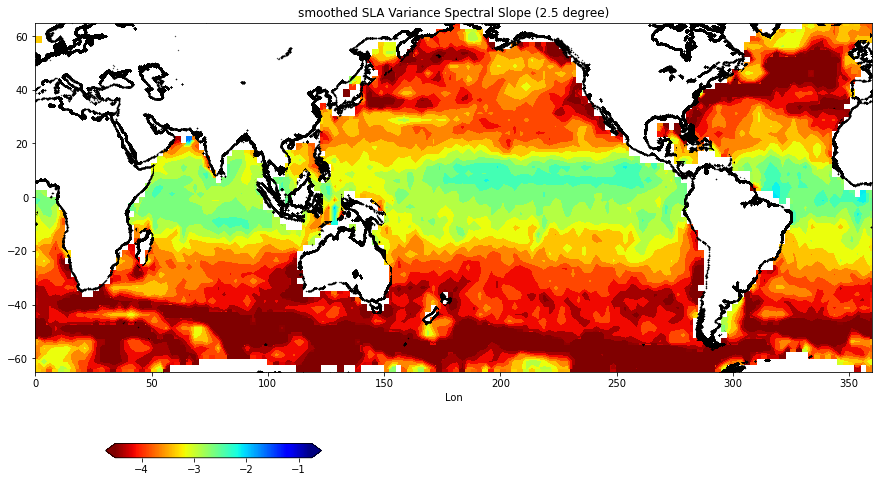

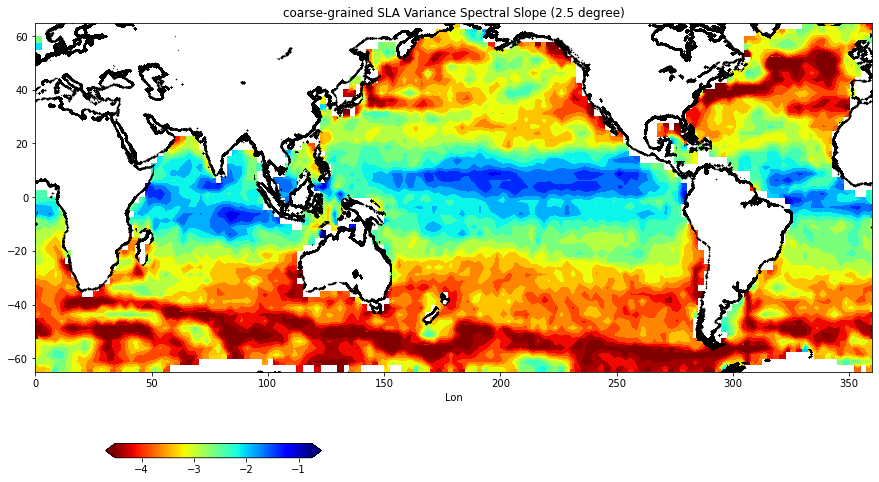

In [57]:
cbpos = [0.19, 0.05, 0.2, 0.025]
f, ax1 = plt.subplots(1, 1, figsize=(15, 8))
levs = np.arange(-4.5, -0.5, 0.25)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
# ax1.scatter(lon_t, lat_t, color='k', s=0.01, zorder=2)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_slope), vmin=levs[0], vmax=levs[-1], zorder=0, cmap=plt.get_cmap('jet_r'))
ax1.contourf(lon_bin_c, lat_bin_c, np.transpose(mean_slope), levels=levs, cmap=plt.get_cmap('jet_r'))
ax1.set_xlabel('Lon')
ax1.set_title(r'SLA Variance Spectral Slope (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
# ax1.set_xlim([150, 250])
# ax1.set_ylim([0, 60])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig(this_sat + '_slopes.jpg', dpi=300)

f, ax1 = plt.subplots(1, 1, figsize=(15, 8))
ax1.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_slope_smooth), vmin=levs[0], vmax=levs[-1], zorder=0, cmap=plt.get_cmap('jet_r'))
ax1.contourf(lon_bin_c, lat_bin_c, np.transpose(mean_slope_smooth), levels=levs, cmap=plt.get_cmap('jet_r'))
ax1.set_xlabel('Lon')
ax1.set_title(r'smoothed SLA Variance Spectral Slope (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig(this_sat + '_slopes_smooth_' + filter_type + '.jpg', dpi=300)

f, ax1 = plt.subplots(1, 1, figsize=(15, 8))
ax1.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_slope_coarse), vmin=levs[0], vmax=levs[-1], zorder=0, cmap=plt.get_cmap('jet_r'))
ax1.contourf(lon_bin_c, lat_bin_c, np.transpose(mean_slope_coarse), levels=levs, cmap=plt.get_cmap('jet_r'))
ax1.set_xlabel('Lon')
ax1.set_title(r'coarse-grained SLA Variance Spectral Slope (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig(this_sat + '_slopes_coarsened_' + filter_type + '.jpg', dpi=300)


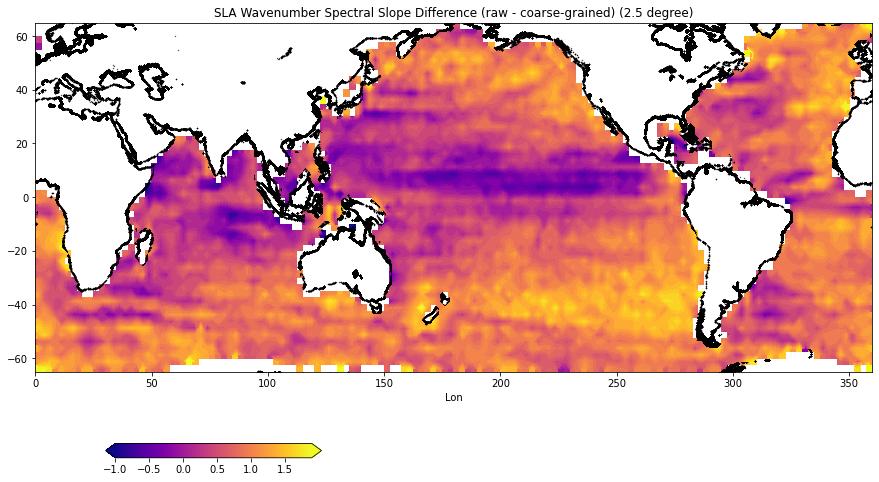

In [61]:
levs = np.arange(-1, 2, 0.1)
f, ax1 = plt.subplots(1, 1, figsize=(15, 8))
ax1.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, (np.transpose(mean_slope) - np.transpose(mean_slope_coarse)), vmin=levs[0], vmax=levs[-1], zorder=0, cmap=plt.get_cmap('plasma'))
ax1.contourf(lon_bin_c, lat_bin_c, (np.transpose(mean_slope) - np.transpose(mean_slope_coarse)), levels=levs, cmap=plt.get_cmap('plasma'))
ax1.set_xlabel('Lon')
ax1.set_title(r'SLA Wavenumber Spectral Slope Difference (raw - coarse-grained) (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig(this_sat + '_slopes_differences_coarse_' + filter_type + '.jpg', dpi=300)

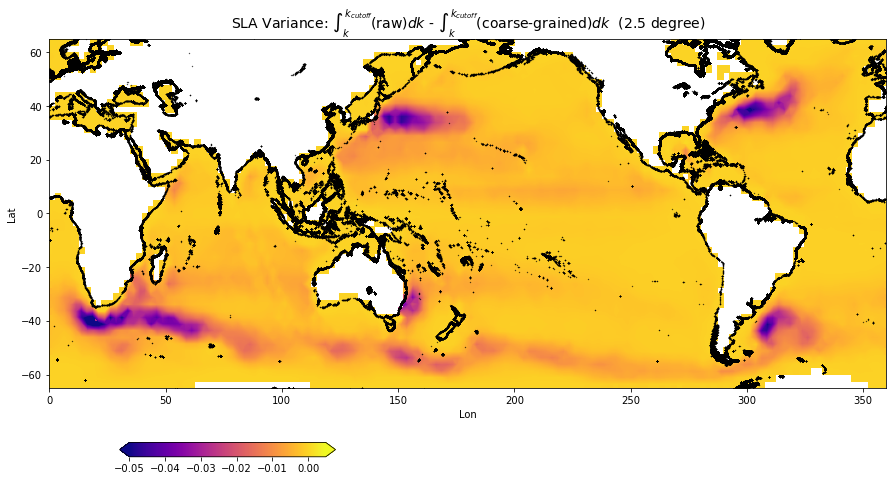

In [66]:
cbpos = [0.19, 0.08, 0.2, 0.025]
levs = np.arange(-.05, 0.005, 0.0001)
f, ax1 = plt.subplots(1, 1, figsize=(15, 8))
ax1.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose((mean_var_large - mean_var_coarse)), vmin=levs[0], vmax=levs[-1], zorder=0, cmap=plt.get_cmap('plasma'))
ax1.contourf(lon_bin_c, lat_bin_c, np.transpose((mean_var_large - mean_var_coarse)), levels=levs, cmap=plt.get_cmap('plasma'), zorder=0)
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'SLA Variance: $\int_{k}^{k_{cutoff}}$(raw)$dk$ - $\int_{k}^{k_{cutoff}}$(coarse-grained)$dk$  (' + \
              str(step) + ' degree)', fontsize=14)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig(this_sat + '_slopes_differences_sharp_coarsened.jpg', dpi=300)

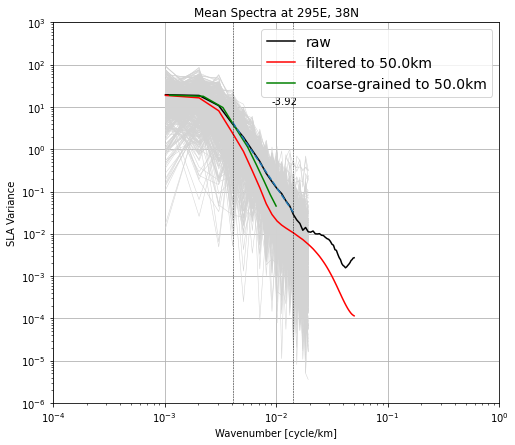

In [69]:
# isolate slopes by choosing lat/lon bin and looking mean slope variability in this domain 
lon_sel = 295
lat_sel = 38
# lon_sel = 321
# lat_sel = 12
lon_win = 1
lat_win = 1
inn_i = np.where((lon_t > (lon_sel - lon_win)) & (lon_t < (lon_sel + lon_win)) & (lat_t > (lat_sel - lat_win)) & (lat_t < (lat_sel + lat_win)))[0]
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn_i]), return_indices=True)
count = 0
count_c = 0
f, ax = plt.subplots(1, 1, figsize=(8, 7))
for tib in tqdm(range(len(ai))):
    inn2 = np.where((lon_record[ai[tib]] > (lon_sel - lon_win)) & (lon_record[ai[tib]] < (lon_sel + lon_win)) & \
                    (lat_record[ai[tib]] > (lat_sel - lat_win)) & (lat_record[ai[tib]] < (lat_sel + lat_win)))[0]  
    inn2_coarse = np.where((lon_coarse_record[ai[tib]] > (lon_sel - lon_win)) &\
                           (lon_coarse_record[ai[tib]] < (lon_sel + lon_win)) &\
                           (lat_coarse_record[ai[tib]] > (lat_sel - lat_win)) &\
                           (lat_coarse_record[ai[tib]] < (lat_sel + lat_win)))[0]
    
    this_f = meso_spectra_out[ai[tib]][:, inn2, :]
    this_f_1 = meso_spectra_smooth_out[ai[tib]][:, inn2, :]
    this_f_coarse = meso_spectra_coarse_out[ai[tib]][:, inn2_coarse, :]
    for kt in range(np.shape(meso_spectra_out[ai[tib]])[0]):  # loop over each cycle 
        for kk in range(len(inn2)):  # loop over lat/lon locations of spectra
            ax.plot(k[1:20], this_f[kt, kk, 1:20], linewidth=0.5, color='#D3D3D3')
            
            if count < 1:
                this_spectra = this_f[kt, kk, :][None, :]
                this_spectra_1 = this_f_1[kt, kk, :][None, :]
            else:
                this_spectra = np.concatenate((this_spectra, this_f[kt, kk, :][None, :]), axis=0)
                this_spectra_1 = np.concatenate((this_spectra_1, this_f_1[kt, kk, :][None, :]), axis=0)
            count = count + 1
                
        for kk in range(len(inn2_coarse)):
            if count_c < 1:
                this_spectra_coarse = this_f_coarse[kt, kk, :][None, :]
            else:
                this_spectra_coarse = np.concatenate((this_spectra_coarse, this_f_coarse[kt, kk, :][None, :]), axis=0)
            count_c = count_c + 1 

ax.plot(k[1:], np.nanmean(this_spectra, axis=0)[1:], linewidth=1.5, color='k', label='raw')
ax.plot(k[1:], np.nanmean(this_spectra_1, axis=0)[1:], linewidth=1.5, color='r', \
        label='filtered to ' + str(coarsening_factor * hor_grid_spacing) + 'km')
ax.plot(k_coarse[1:], np.nanmean(this_spectra_coarse, axis=0)[1:], linewidth=1.5, color='g', \
        label='coarse-grained to ' + str(coarsening_factor * hor_grid_spacing) + 'km')
local_spectra = np.nanmean(this_spectra, axis=0)
meso_p_i = np.polyfit(np.log10(k[meso_ind]), np.log10(local_spectra[meso_ind]), 1)
ax.plot(k[meso_ind], 10**np.polyval(meso_p_i, np.log10(k[meso_ind])), linestyle='--', linewidth=1.5)
ax.text(np.nanmean(k[meso_ind]), (10**np.polyval(meso_p_i, np.log10(k[meso_ind])))[1] + 10**1, np.round(meso_p_i[0], 2))
ax.plot([k[meso_ind[0]], k[meso_ind[0]]], [10**(-6), 10**5], color='k', linestyle='--', linewidth=0.5)
ax.plot([k[meso_ind[-1]], k[meso_ind[-1]]], [10**(-6), 10**5], color='k', linestyle='--', linewidth=0.5)

ax.set_title('Mean Spectra at ' + str(lon_sel) + 'E, ' + str(lat_sel) + 'N')
ax.set_ylim([10**(-6), 10**(3)])
ax.set_xlim([1*10**(-4), 10**(0)])
ax.set_xscale('log')
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_xlabel('Wavenumber [cycle/km]')
ax.set_ylabel('SLA Variance')
ax.grid()
plt.show()    
f.savefig(this_sat + '_sample_slope_at' + str(lon_sel) + 'E, ' + str(lat_sel) + 'N_' + filter_type + '.jpg', dpi=300)